**Step 1: data pre-process steps and initial feature extraction**


**Step 2: Data insights and visualization including drop outliers**<br/>
* Basic stats, dividends per year, abnormal return hist given div direction<br/>
* outliers range?


**Step 3: Base line model**<br/>
* Should we split train/test in the research linear regression? same for the regular one
* Which columns should I drop?


**Step 4: Analysis of error + conclusions (years 2008-2009)**


**Step 5: Sensitivity analysis (size of window)**


**Step 6: Run new model (Regression) (naive + feature handler)**


**Step 7: Run different Regression models and compare**


**Step 8: Discrete Models**


**Step 9: Cross Validation, results and conclusions**


In [61]:
import imp
imp.reload(main)
imp.reload(regression_models)
imp.reload(feature_handler)

<module 'feature_handler.feature_handler' from 'C:\\Users\\Owner\\GIT\\DS2\\DataSci\\feature_handler\\feature_handler.py'>

In [62]:
from aggregate import aggregate
from aggregate import capm_params
from feature_handler import feature_handler
from run_model import regression_models
import pandas as pd
import numpy as np
import main
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

# Data Science Workshop - Project notebook

TODO: introduction

### Step 0: Notebook intialization
seed: 
>We ran the notebook using seed = 10

run_speed:
>3 - fastest (immediate)<br/>
    2 - avrage<br/>
    1 - slowest

In [63]:
seed = 10
random.seed(seed)
np.random.seed(seed)
run_speed = 3

### Step 1: data pre-process steps and initial feature extraction
This step include very intial data pre-processing:
1. Drop NaNs - droping them is easy decision because there aren't alot samples with NaNs.
2. Take care of data types - basic conversion from string to float
3. Add dividend change and dividend change direction - infer from the data
4. Add the abnormal return feature (which is the value we will try to predict and explain)

Step 4 includes not just the abnormal return' but more featuers.<br/>
Some of them are used to generate the abnoraml return, some aren't.<br/>
Those features meaning is as follows:

>$expected\_i = \alpha + \beta*sp\_i$<br/>
$ar\_i = expected\_i - actual\_i$<br/>
$aar\_i = \frac{\sum_{k=-i}^i{ar_k}}{2i+1}$<br/>

As of now, we will think of "aar_5" as our response. <br/>
("aar_i%" will be discussed later)

In [64]:
df = pd.read_csv("aggregated_data.csv")

rows_before = df.shape[0]
df.dropna(inplace=True)
rows_after = df.shape[0]
print("Dropped {} rows with NaN values".format(rows_before-rows_after))

# dividend_amount to integer
df = feature_handler.create_div_amount_num(df)
df.drop(df[df["div_amount_num"] == 0].index, inplace=True)
df.drop("dividend_amount", axis = 1, inplace = True)

# Add dividend direction and dividend change
df = feature_handler.gen_div_direction_and_change(df)

# Add abnormal return data
df = feature_handler.create_abnormal_return(df)
df.reset_index(inplace = True, drop = True)
if run_speed <= 1: df.to_csv("data_with_ar.csv", index=False)

Dropped 86 rows with NaN values
################# Creating div_amount_num #################
Found 77 samples were dividend_amount did not start with $ - drop
Found 4 divdends that were eqaul to 0 - drop
>>> Finished. Total dropped rows due to invalid dividend info: 81
################# Creating div_direction and div_change ###
>>> Finished
################# Creating abnormal return related features ###
	feature type = expected_t		11 features
	feature type = ar_t		11 features
	feature type = aar_t		6 features
	feature type = aar_t%		6 features
>>> Finished. Created 34 features


In [65]:
display(df.head(1))
print(list(df.columns))

,company_name,symbol,industry,sector,dividend_date,alpha,beta,price_t-5,vol_t-5,sp_price_t-5,...,aar_2,aar_3,aar_4,aar_5,aar_0%,aar_1%,aar_2%,aar_3%,aar_4%,aar_5%
0,"American Airlines Group, Inc.",AAL,Air Freight/Delivery Services,Transportation,2019-10-22,-33.847291,0.020567,27.93,6709600.0,2997.949951,...,1.724005,2.212617,2.456924,2.497174,0.017549,0.017393,0.024743,0.033998,0.039134,0.040636


['company_name', 'symbol', 'industry', 'sector', 'dividend_date', 'alpha', 'beta', 'price_t-5', 'vol_t-5', 'sp_price_t-5', 'sp_vol_t-5', 'price_t-4', 'vol_t-4', 'sp_price_t-4', 'sp_vol_t-4', 'price_t-3', 'vol_t-3', 'sp_price_t-3', 'sp_vol_t-3', 'price_t-2', 'vol_t-2', 'sp_price_t-2', 'sp_vol_t-2', 'price_t-1', 'vol_t-1', 'sp_price_t-1', 'sp_vol_t-1', 'price_t0', 'vol_t0', 'sp_price_t0', 'sp_vol_t0', 'price_t1', 'vol_t1', 'sp_price_t1', 'sp_vol_t1', 'price_t2', 'vol_t2', 'sp_price_t2', 'sp_vol_t2', 'price_t3', 'vol_t3', 'sp_price_t3', 'sp_vol_t3', 'price_t4', 'vol_t4', 'sp_price_t4', 'sp_vol_t4', 'price_t5', 'vol_t5', 'sp_price_t5', 'sp_vol_t5', 'year', 'month', 'quarter', 'MV Debt Ratio', 'BV Debt Ratio', 'Effective Tax Rate', 'Std Deviation In Prices', 'EBITDA/Value', 'Fixed Assets/BV of Capital', 'Capital Spending/BV of Capital', 'div_amount_num', 'div_direction', 'div_change', 'expected_t-5', 'expected_t-4', 'expected_t-3', 'expected_t-2', 'expected_t-1', 'expected_t0', 'expected_t1

### Step 2: Data insights and visualization including drop outliers

In [66]:
_ = main.print_basic_stats(df)

Data Stats:
	#Samples: 39746
	#Features: 98
	#Samples with NaNs: 0


In [67]:
df_aar_5_no_outliers = main.remove_outliers(df, range_min = -50 , range_max = 50)

Removed 57 outliers


One more thing we had in mind is to normalize the abnormal return, that's why we created "aar_i%",<br/>
which is the same as "aar_i" but divided by the mean of the expected values:<br/>
$aar\_i\% = \frac{aar\_i}{(\sum_{k=-i}^{i}{expected_k})/(2i+1)}$<br/>
So we will predict arr_5% instead of aar_5

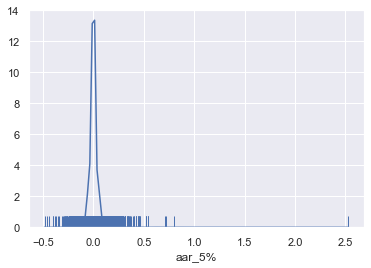

In [122]:
#show dist of aar_5%
_ = sns.distplot(df['aar_5%'], hist = False, rug = True)

In [69]:
df_aar_5_precent_no_outliers = main.remove_outliers(df, range_min = -1, range_max = 1, y_col = 'aar_5%')


Removed 1 outliers


### Step 3: Base line model
This step include to parts:
1. Research replication
2. Run simple linear regression to use as a baseline

Recall we are trying to predict "arr_5", hence we will not use any related features.
In addition we still have some categorical features, we will use dummies on the "sector" feature and drop the rest. This leaves us with:

In [70]:
baseline_model_data = main.generate_bl_model_data(df_aar_5_precent_no_outliers, print_ = True, y_col = 'aar_5%')

Baseline model features: {'Fixed Assets/BV of Capital', 'div_change', 'alpha', 'div_amount_num', 'Capital Spending/BV of Capital', 'beta', 'Effective Tax Rate', 'BV Debt Ratio', 'EBITDA/Value', 'Std Deviation In Prices', 'year', 'month', 'MV Debt Ratio', 'div_direction', 'quarter'}


**Research replication**<br/>
Previous research, looked only at the samples where $div\_change \neq 0$, using linear regression they recieved R^2 of abot 7%, we will try to replicate it.

In [71]:
#Regression model - Research
research_baseline_model_data = main.generate_bl_model_data(df_aar_5_no_outliers, print_ = False, y_col = 'aar_5')
research_baseline_model_data = research_baseline_model_data[research_baseline_model_data['div_direction'] != 0]
_ = regression_models.run_linear_reg(research_baseline_model_data) 

R^2: 0.012338446092088784


TODO: discuss the reuslt

**Linear regression as baseline**<br/>
Use simple linear regression on our data:

In [72]:
baseline_model_data = main.generate_bl_model_data(df_aar_5_precent_no_outliers, print_ = False, y_col = 'aar_5%')
_ = regression_models.run_linear_reg(baseline_model_data, y_col = 'aar_5%')

R^2: 0.00376855343080873


TODO: Discuss the results

### Step 4: Analysis of error for the base line model+ conclusions (years 2008-2009)
TODO: visualize and discuss

In [73]:
baseline_model_data_no20089 = main.remove_2008_2009(baseline_model_data)
_ = regression_models.run_linear_reg(baseline_model_data_no20089, y_col = "aar_5%")

Removed 3219 samples from years 2008 - 2009
R^2: 0.0034791873471685664


### Step 5: Sensitivity analysis (size of window)

As a result of the disapointing results, we will try to revisit our assumptions, in particular the "window" size we chose.<br/>
TODO: explain why windows size of -1,5

In [134]:
start, end = -1 ,5
y_col = "aar_asy{}_{}%".format(str(start), str(end))
baseline_data_ws = main.generate_bl_model_data(df_aar_5_precent_no_outliers,\
                                                             window_size=(start, end),\
                                                             drop_08_09 = True,
                                                             print_ = 0)
_ = regression_models.run_linear_reg(baseline_data_ws, y_col = y_col)

R^2: 0.005622530757547817


TODO: discuss the results

### Step 6: Run new model (Regression) (naive + feature handler)

We will consider two new features, since we normalized our response, it's make sense to also normalize in the same way the new features that were added from the window size change.<br/>
$delta\_\%\_{t-5}=\frac{price_{t-5} - expected_{t-5}}{expected_{t-5}}$

$delta\_\%\_{t-4}=\frac{price_{t-4} - expected_{t-4}}{expected_{t-4}}$

In [106]:
ws, y_col = 1 , 'aar_1%'
baseline_data_ws1 = main.generate_bl_model_data(df,
                                             window_size=ws,\
                                             y_col=y_col,\
                                             drop_08_09 = True,
                                             print_ = 0)

baseline_data_ws1 = feature_handler.gen_delta_precent_t(baseline_data_ws1)
_ = regression_models.run_linear_reg([['delta_%_t-4', y_col]], y_col = y_col, print_summary= 0)

Created delta_%_t-4, delta_%_t-5 features
R^2: 0.5097399921639895


### Step 7: Run different Regression models and compare
Now we want to leave the linear regression model, and use more complex models.<br/>
First we will split the data into train and test.

In [131]:
pred_data = baseline_data_ws1
X_train, X_test, y_train, y_test = main.split_test_train(pred_data, y_col = 'aar_1%', test_size = 0.33)

### Step 8: Discrete Models

### Step 9: Cross Validation, results and conclusions